
🎯 HASIL SELEKSI FITUR (SelectKBest - 8 Fitur Terbaik):
Fitur Optimal: ['Time_Interval_Entropy', 'Tweet_Rate_Per_Day', 'Follower_Count', 'Follower_Density', 'Mean_Mention_Count', 'Std_Mention_Count', 'Mean_URL_Count', 'Verified']
--------------------------------------------------

🚀 Memulai Hyperparameter Tuning SVM...
Fitting 5 folds for each of 11 candidates, totalling 55 fits
✅ Tuning Selesai dalam 12.84 detik.

🏆 MODEL SVM TERBAIK DITEMUKAN:
Kernel Terbaik: rbf
Hyperparameter Terbaik: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
--------------------------------------------------

📊 HASIL EVALUASI PERFORMA MODEL SVM (Pada Data Testing)
1. Akurasi (Accuracy): 0.6522
2. Presisi (Precision): 0.6364
3. Recall (Sensitivitas): 0.6364
4. F1-Score: 0.6364
--------------------------------------------------

🎯 CONFUSION MATRIX:
True Negative (TN): 8 (Non-Bot diprediksi Non-Bot)
False Positive (FP): 4 (Non-Bot diprediksi Bot)
False Negative (FN): 4 (Bot diprediksi Non-Bot)
True Positive (TP): 

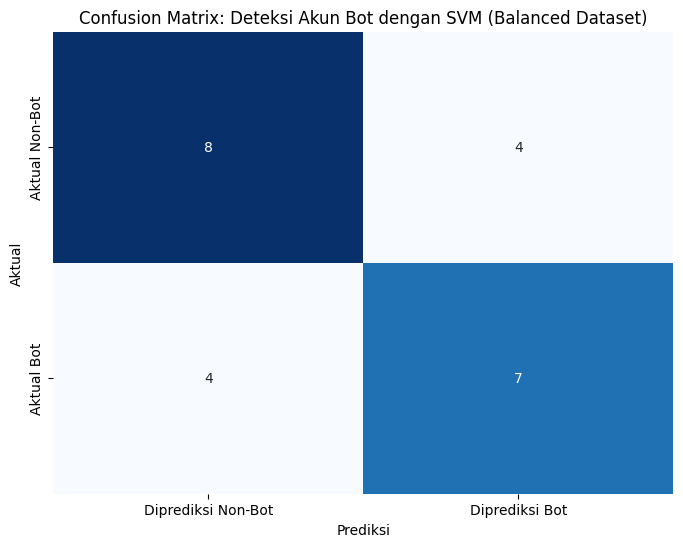

C:\Users\ACER\AppData\Local\Temp\ipykernel_16680\1554080026.py:247: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


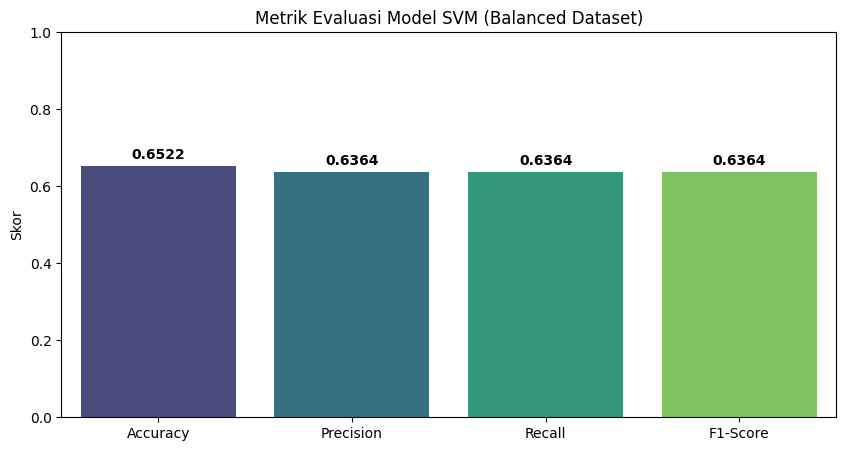


✅ ANALISIS SINGKAT HASIL:
Model SVM dengan hyperparameter terbaik mencapai F1-Score 0.6364.


In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Fungsi TIE
def calculate_tie(timestamps):
    """Menghitung Time Interval Entropy (TIE) dari daftar timestamps tweet."""
    try:
        timestamps = timestamps.sort_values().astype(np.int64) // 10**9
        
        # Jika kurang dari 2 timestamp, tidak ada interval
        if len(timestamps) < 2:
            return 0.0
        
        # Hitung interval antar tweet
        intervals = np.diff(timestamps)
        
        # Jika semua interval 0 (tweet di waktu sama), atau tidak ada interval
        if len(intervals) == 0 or intervals.max() == 0:
            return 0.0
        
        # Buat bins untuk histogram
        bins = np.logspace(0, np.log10(intervals.max() + 1), 50)
        counts, _ = np.histogram(intervals, bins=bins)
        
        # Hitung total intervals
        total_intervals = counts.sum()
        
        # Jika total_intervals adalah 0, return 0
        if total_intervals == 0:
            return 0.0
        
        # Hitung probabilitas (dengan pengecekan divide by zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            probabilities = counts / total_intervals
            probabilities = probabilities[probabilities > 0]
        
        # Jika tidak ada probabilitas valid, return 0
        if len(probabilities) == 0:
            return 0.0
        
        # Hitung entropy
        entropy = -np.sum(probabilities * np.log2(probabilities))
        
        # Jika entropy adalah NaN atau inf, return 0
        if np.isnan(entropy) or np.isinf(entropy):
            return 0.0
            
        return entropy
        
    except Exception as e:
        # Jika ada error apapun, return 0
        return 0.0

# LANGKAH 1: LOAD DATA
file_path = 'x_dataset/bot_detection_data.csv'
df = pd.read_csv(file_path)


# Initial preprocessing 
df['Created At'] = pd.to_datetime(df['Created At'])
df['Tweet Length'] = df['Tweet'].str.len()

# LANGKAH 2: FEATURE ENGINEERING (SAMA PERSIS!)
df_profile = df.groupby('User ID').agg(
    Follower_Count=('Follower Count', 'last'),
    Verified=('Verified', 'last'),
    Bot_Label=('Bot Label', 'last'),
    First_Tweet_Time=('Created At', 'min'),
    Last_Tweet_Time=('Created At', 'max'),
    Tweet_Count=('User ID', 'size')
).reset_index()

df_behavior = df.groupby('User ID').agg(
    Mean_Retweet_Count=('Retweet Count', 'mean'),
    Mean_Mention_Count=('Mention Count', 'mean'),
    Mean_URL_Count=('URL Count', 'mean'),
    Mean_Hashtag_Count=('Hashtag Count', 'mean'),
    Mean_Tweet_Length=('Tweet Length', 'mean'),
    Std_Retweet_Count=('Retweet Count', 'std'),
    Std_Mention_Count=('Mention Count', 'std'),
).reset_index()

df_agg = pd.merge(df_profile, df_behavior, on='User ID')

# Menghitung TIE 
tie_scores = df.groupby('User ID')['Created At'].apply(calculate_tie).reset_index(name='Time_Interval_Entropy')
df_final = pd.merge(df_agg, tie_scores, on='User ID')

# Derived features 
df_final['Account_Age_Seconds'] = (df_final['Last_Tweet_Time'] - df_final['First_Tweet_Time']).dt.total_seconds()
df_final['Account_Age_Seconds'] = df_final['Account_Age_Seconds'].apply(lambda x: x if x > 0 else 1)
df_final['Tweet_Rate_Per_Day'] = (df_final['Tweet_Count'] / df_final['Account_Age_Seconds']) * (24 * 3600)
df_final['Follower_Density'] = df_final['Follower_Count'] / df_final['Account_Age_Seconds']
df_final['Engagement_Score'] = df_final['Mean_Retweet_Count'] + df_final['Mean_Mention_Count']
df_final = df_final.fillna(0)



# Pisahkan bot dan non-bot
bot_users = df_final[df_final['Bot_Label'] == 1]
non_bot_users = df_final[df_final['Bot_Label'] == 0]


# Ambil jumlah minimum
min_samples = min(len(bot_users), len(non_bot_users))

# Resample untuk balance
bot_balanced = resample(bot_users, 
                       replace=False,
                       n_samples=min_samples,
                       random_state=42)

non_bot_balanced = resample(non_bot_users,
                           replace=False,
                           n_samples=min_samples,
                           random_state=42)

# Gabungkan dan shuffle
df_final_balanced = pd.concat([bot_balanced, non_bot_balanced])
df_final_balanced = df_final_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


# LANJUTKAN DENGAN DATA YANG SUDAH BALANCED

# Definisikan Fitur (X) dan Target (y)
feature_cols = [
    'Time_Interval_Entropy',
    'Tweet_Rate_Per_Day',
    'Follower_Count',
    'Follower_Density',
    'Engagement_Score',
    'Mean_Retweet_Count',
    'Mean_Mention_Count',
    'Std_Retweet_Count',
    'Std_Mention_Count',
    'Mean_URL_Count',
    'Mean_Hashtag_Count',
    'Mean_Tweet_Length',
    'Verified'
]

X = df_final_balanced[feature_cols].copy()
y = df_final_balanced['Bot_Label']
X['Verified'] = X['Verified'].astype(int)

# LANGKAH 3: PEMBAGIAN DATA TRAINING DAN TESTING
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LANGKAH 4: SCALING DATA (STANDARISASI)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

X_train_model = X_train_scaled
y_train_model = y_train

# LANGKAH 5: SELEKSI FITUR SISTEMATIS
k = 8
selector = SelectKBest(score_func=f_classif, k=k)
selector.fit(X_train_model, y_train_model)

selected_features_indices = selector.get_support(indices=True)
selected_features = [feature_cols[i] for i in selected_features_indices]

print(f"\n🎯 HASIL SELEKSI FITUR (SelectKBest - {k} Fitur Terbaik):")
print(f"Fitur Optimal: {selected_features}")
print("-" * 50)

X_train_selected = X_train_model[selected_features]
X_test_selected = X_test_scaled[selected_features]

# LANGKAH 6: MODEL TRAINING DAN HYPERPARAMETER TUNING
param_grid = [
    {'kernel': ['linear'], 'C': [10, 100]},
    {'kernel': ['rbf'], 'C': [10, 100, 1000], 'gamma': [0.00001, 0.0001, 0.001]}
]

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

print("\n🚀 Memulai Hyperparameter Tuning SVM...")
start_time = time.time()
grid_search.fit(X_train_selected, y_train_model)
end_time = time.time()
print(f"✅ Tuning Selesai dalam {end_time - start_time:.2f} detik.")

best_svm_model = grid_search.best_estimator_

print("\n🏆 MODEL SVM TERBAIK DITEMUKAN:")
print(f"Kernel Terbaik: {best_svm_model.kernel}")
print(f"Hyperparameter Terbaik: {grid_search.best_params_}")
print("-" * 50)

# LANGKAH 7: EVALUASI PERFORMA MODEL LENGKAP
y_pred = best_svm_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n📊 HASIL EVALUASI PERFORMA MODEL SVM (Pada Data Testing)")
print(f"1. Akurasi (Accuracy): {accuracy:.4f}")
print(f"2. Presisi (Precision): {precision:.4f}")
print(f"3. Recall (Sensitivitas): {recall:.4f}")
print(f"4. F1-Score: {f1:.4f}")
print("-" * 50)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

print("\n🎯 CONFUSION MATRIX:")
print(f"True Negative (TN): {tn} (Non-Bot diprediksi Non-Bot)")
print(f"False Positive (FP): {fp} (Non-Bot diprediksi Bot)")
print(f"False Negative (FN): {fn} (Bot diprediksi Non-Bot)")
print(f"True Positive (TP): {tp} (Bot diprediksi Bot)")
print("-" * 50)

print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Non-Bot (0)', 'Bot (1)'], zero_division=0))

# LANGKAH 8: VISUALISASI HASIL
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Diprediksi Non-Bot', 'Diprediksi Bot'],
            yticklabels=['Aktual Non-Bot', 'Aktual Bot'])
plt.title('Confusion Matrix: Deteksi Akun Bot dengan SVM (Balanced Dataset)')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.ylim(0.0, 1.0)
plt.title('Metrik Evaluasi Model SVM (Balanced Dataset)')
plt.ylabel('Skor')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
plt.show()

print("\n✅ ANALISIS SINGKAT HASIL:")
print(f"Model SVM dengan hyperparameter terbaik mencapai F1-Score {f1:.4f}.")
